In [196]:
import math
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.io as sio

from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import KernelPCA

from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [191]:
def plot_roc(df_test_out, preds):
    # Results ROC
    fpr, tpr, thresholds = roc_curve(df_test_out, preds)
    roc_score = roc_auc_score(df_test_out, preds)
    fig = plt.figure(figsize=(10,5))
    plt.grid(color='#919191', linestyle=':', linewidth=1)
    plt.plot(fpr, tpr, label='MPL')
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Decisão aleatória')
    plt.title('Curva ROC')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    plt.legend()
    plt.show()
    fig.savefig('mlp_roc.png', dpi=600)
    print("ROC Score", roc_score)

In [192]:
def plot_history(history):
    # plot training history
    fig = plt.figure(figsize=(10,5))
    plt.grid(color='#919191', linestyle=':', linewidth=1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.grid(True)
    plt.legend()
    fig.savefig('mlp_history.png', dpi=600)
    plt.show()

In [193]:
# Read and build DataFrames
df_test = sio.loadmat('dados_teste.mat')
df_train = sio.loadmat('dados_treinamento.mat')
df_val = sio.loadmat('dados_val.mat')

df_test = pd.DataFrame(np.concatenate((df_test['Xt'], df_test['yt']), axis=1),columns=['x1', 'x2', 'y'])
df_train = pd.DataFrame(np.concatenate((df_train['X'], df_train['y']), axis=1),columns=['x1', 'x2', 'y'])
df_val = pd.DataFrame(np.concatenate((df_val['Xval'], df_val['yval']), axis=1),columns=['x1', 'x2', 'y'])

# Data normalization and encoding
scaler = StandardScaler()
df_train_out = df_train.loc[:,'y'].replace(-1, 0)
df_train_inp = df_train.drop('y', axis=1)
scaler.fit(df_train_inp) 

df_train_inp_scaled = pd.DataFrame(scaler.transform(df_train_inp), columns=['x1','x2'])

df_val_out = df_val.loc[:,'y'].replace(-1, 0)
df_val_inp = df_val.drop('y', axis=1)
df_val_inp_scaled = pd.DataFrame(scaler.transform(df_val_inp), columns=['x1','x2'])


df_test_out = df_test.loc[:,'y'].replace(-1, 0)
df_test_inp = df_test.drop('y', axis=1)
df_test_inp_scaled = pd.DataFrame(scaler.transform(df_test_inp), columns=['x1','x2'])




In [194]:

# transformer = KernelPCA(n_components=2, kernel='linear')
# transformer.fit(df_train_inp)
# df_train_inp_kpca = pd.DataFrame(transformer.transform(df_train_inp))
# print(df_train_inp.corr())
# print(df_train_inp_kpca.corr())


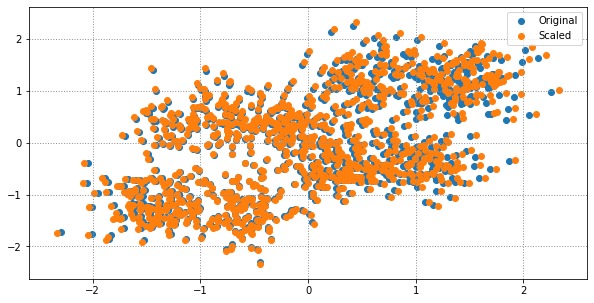

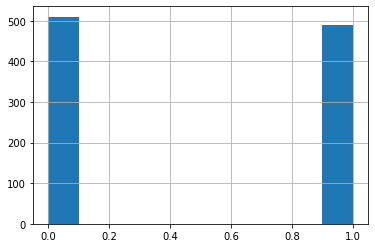

In [195]:
fig = plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.scatter(df_train_inp['x1'],df_train_inp['x2'], label='Original')
plt.scatter(df_train_inp_scaled['x1'],df_train_inp_scaled['x2'], label='Scaled') 
plt.grid(True)
plt.legend()
fig.savefig('mlp_inp_scaled.png', dpi=600)
plt.show()
df_train_out.hist()
plt.savefig('mlp_out_scaled.png', dpi=600)

In [203]:
# MLP
neuron_num = 35
mlp_weight = 'mlp_weight_ne'+str(neuron_num)
callbacks = [
    EarlyStopping(monitor='val_loss', \
        min_delta=0.01, patience=200, verbose=1,\
        mode='min', baseline=0.001, restore_best_weights=False),
    ModelCheckpoint(mlp_weight, monitor='val_loss', save_best_only=True, verbose=1)
]
model = Sequential()
# model.add(Dense(neuron_num, input_dim=2, activity_regularizer=l1_l2(0.01, 0.01)))
model.add(Dense(neuron_num, input_dim=2))
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [204]:
# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='binary_crossentropy', optimizer='RMSprop')
if os.path.isfile(mlp_weight):
    model.load_weights(mlp_weight)
print("Training...")
history = model.fit(\
    df_train_inp_scaled, df_train_out, validation_data=(df_val_inp_scaled, df_val_out),callbacks=callbacks,\
    epochs=500, batch_size=10, verbose=1, shuffle=True, use_multiprocessing=True)
print('Predicting...')


Training...
Train on 1000 samples, validate on 1000 samples
Epoch 1/500
1000/1000 [==============================] - 0s 443us/step - loss: 0.6540 - val_loss: 0.6126

Epoch 00001: val_loss improved from inf to 0.61255, saving model to mlp_weight_ne35
Epoch 2/500
1000/1000 [==============================] - 0s 264us/step - loss: 0.5916 - val_loss: 0.5823

Epoch 00002: val_loss improved from 0.61255 to 0.58226, saving model to mlp_weight_ne35
Epoch 3/500
1000/1000 [==============================] - 0s 246us/step - loss: 0.5701 - val_loss: 0.5661

Epoch 00003: val_loss improved from 0.58226 to 0.56607, saving model to mlp_weight_ne35
Epoch 4/500
1000/1000 [==============================] - 0s 255us/step - loss: 0.5592 - val_loss: 0.5570

Epoch 00004: val_loss improved from 0.56607 to 0.55696, saving model to mlp_weight_ne35
Epoch 5/500
1000/1000 [==============================] - 0s 271us/step - loss: 0.5430 - val_loss: 0.5505

Epoch 00005: val_loss improved from 0.55696 to 0.55045, saving

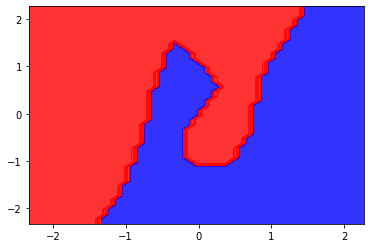

In [205]:
# Região decisão dados de treino !
h = 0.1
x1_min, x1_max = df_train_inp_scaled['x1'].min(), df_train_inp_scaled['x1'].max()
x2_min, x2_max = df_train_inp_scaled['x2'].min(), df_train_inp_scaled['x2'].max()
 
xx, yy = np.meshgrid(
    np.arange(x1_min, x1_max, h),
    np.arange(x2_min, x2_max, h))

Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z,colors=['red','red','red','red','red','red','blue'], alpha=0.8)
plt.savefig('mpl_decision.png')

1000/1000 [==============================] - 0s 23us/step


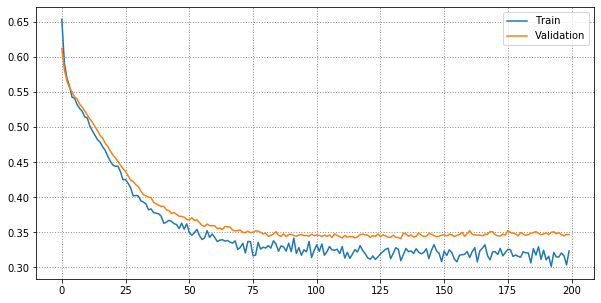

1000/1000 [==============================] - 0s 20us/step


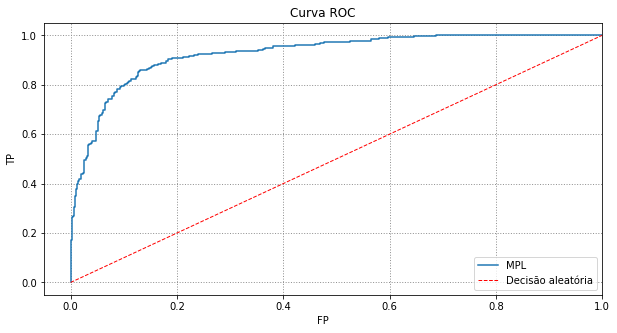

ROC Score 0.9261373423223134
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       499
         1.0       0.88      0.86      0.87       501

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [208]:
preds = model.predict(df_test_inp_scaled, verbose=1)
class_pred = model.predict_classes(df_test_inp_scaled, verbose=1)

plot_history(history)
plot_roc(df_val_out, model.predict(df_val_inp_scaled, verbose=1))
print(classification_report(\
    df_test_out.to_numpy(), class_pred))


In [207]:
df_train_inp_scaled

,x1,x2
0,0.626865,0.017208
1,1.047823,0.627189
2,0.512837,1.048167
3,-0.387538,0.513155
4,1.212552,-0.387262
...,...,...
995,1.642612,-0.674162
996,1.682465,1.642985
997,0.468711,1.682840
998,-0.225447,0.469028
